#### Functions (IGNORE)

In [1]:
# import packages that will be used for analysis
import random

# set the random set
random.seed(4)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data
- Get data from start to end
- Download stock data for different periods
- Get adjusted sector ETF nd

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Stochastic Modeling

In [5]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Bollinger Bands

In [6]:
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Signal'] = 'Hold'

        data['Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', 'Hold'))

        return data

In [7]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')
    return data

In [8]:
# create a function that plots the bollinger bands and actions
def plot_with_boll_bands(bollinger_data,title):
    """
    bollinger_data: holds the signals and bollinger data
    """
    buy_data = []
    sell_data = []

    for index, row in bollinger_data.iterrows():
        if row['Signal']=='Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])

        else:
            sell_data.append(np.nan)

    bollinger_data['Buy Data'] = buy_data
    bollinger_data['Sell Data'] = sell_data

    plt.figure(figsize=(12,8))
    
    plt.plot(bollinger_data.index,bollinger_data['Adj Close'],color='grey',label='Adjusted Close Price')
    plt.plot(bollinger_data.index,bollinger_data['lower_band'],color='green',label='Lower Band',linestyle='-')
    plt.plot(bollinger_data.index,bollinger_data['upper_band'],color='red',label='Upper Band',linestyle='-')
    plt.scatter(bollinger_data.index,bollinger_data['Buy Data'],marker='o',color='green',label='Buy Signal')
    plt.scatter(bollinger_data.index,bollinger_data['Sell Data'],marker='o',color='red',label='Sell Signal')

    #plt.plot(investment_tracking_df['Date'],investment_tracking_df['Investment Value'])
    # goal is to make a subplot which shows both the investment and bollinger bands

    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.title(title)
    plt.ylabel('Price')
    plt.legend()
    plt.show()

##### Signals

In [9]:
def list_signals(stock_data_with_signals, tickers, periods):
    # Initialize a dictionary to store Buy/Sell signals
    signals_data = {period: {ticker: {'Buy': [], 'Sell': []} for ticker in tickers} for period in periods}

    for period in periods:
        for ticker in tickers:
            # Loop over rows in stock data for the specific period and ticker
            for idx, row in stock_data_with_signals[period][ticker].iterrows():
                if row['Signal'] == 'Buy':
                    # Append the index of the Buy signal
                    signals_data[period][ticker]['Buy'].append(pd.to_datetime(idx))
                elif row['Signal'] == 'Sell':
                    # Append the index of the Sell signal
                    signals_data[period][ticker]['Sell'].append(pd.to_datetime(idx))

    return signals_data

In [10]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    bb_nested_dict = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        bb_nested_dict[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return bb_nested_dict

##### Plot data

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

##### Stock Investment History

In [12]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

In [13]:
from datetime import timedelta
import numpy as np
import pandas as pd

def zip_calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_date.keys()}
    np.random.seed(42)


    # Loop through each economic period
    for period in periods_date.keys():
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=110))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]

            # Initialize variables for each ticker
            account_balance = {ticker: future_investments for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: initial_investment/adj_close_period[ticker].iloc[0] for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: initial_investment for ticker in tickers}   # Initialize share value for each ticker

            # Iterate over each day in the Bollinger Band signals and adjusted close prices
            for row_idx, (signals_row, adj_close_row) in enumerate(zip(bb_signals_period.iterrows(), adj_close_period.iterrows())):
                signals_row = signals_row[1]  # Extract the actual row (signals) - don't need the index
                adj_close_row = adj_close_row[1]  # Extract the actual row (adjusted close prices)

                # Now zip over the signal row and the corresponding adjusted close price for each ticker
                for ticker, (signal, adj_close_price) in zip(tickers, zip(signals_row, adj_close_row)):
                    
                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += amount_to_sell

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - (initial_investment + future_investments)
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = (profit / (initial_investment + future_investments)) * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

##### Grid search optimization

In [14]:
# define the different parameters for rolling window and confidence interval
from itertools import product

# create a function that inputs conf interval and rolling average and return a roi

def grid_search_bollinger_bands(etf_data,adj_close_etf_data,param_grid,periods_list,periods_date,tickers,n_sample,initial_investment,future_investment,percent_to_buy,percent_to_sell):
     results =[]


     for rolling_window, confidence_interval in product(param_grid['rolling_windows'],param_grid['confidence_intervals']):

          # create bb signals for the different rolling window and confidence interval combination
          data_nd = bollinger_data_multiple_periods_tickers(periods_list,tickers,etf_data, rolling_window,confidence_interval)

          signals_nd = collect_signals(data_nd,periods_list,tickers)

          # calculate the roi for that combination
          roi_results = zip_calculate_stock_roi(signals_nd,adj_close_etf_data,periods_date,tickers,n_sample,initial_investment,future_investment,percent_to_buy,percent_to_sell)

          # average the roi across all periods and tickers so there is a single value
          average_roi = stochastic_roi(tickers,periods_date,roi_results,'Mean').mean()

          # Append the result (rolling window, confidence interval, average ROI) to the list
          results.append({
          'rolling_window': rolling_window,
          'confidence_interval': confidence_interval,
          'trough':average_roi[0],
            'expansion':average_roi[1],
            'peak':average_roi[2],
            'contraction':average_roi[3],
            'all_data':average_roi[4],
        })

     # Convert the results list to a DataFrame
     roi_df = pd.DataFrame(results)
    
     return roi_df

In [15]:
import numpy as np
import pandas as pd
from itertools import product

def investment_amount_grid_search_bollinger_bands(etf_data, adj_close_etf_data, param_grid, periods_list, periods_date, tickers, n_sample, initial_investment,future_investment,rolling_window,std):
    results = []
    
    # Iterate over combinations of amount_to_buy and amount_to_sell
    for amount_to_buy, amount_to_sell in product(param_grid['amount_to_buy'], param_grid['amount_to_sell']):
        
        # Create Bollinger Bands signals for different rolling windows and confidence intervals
        data_nd = bollinger_data_multiple_periods_tickers(periods_list, tickers, etf_data, rolling_window, std)
        
        # Collect the signals for different periods and tickers
        signals_nd = collect_signals(data_nd, periods_list, tickers)
        
        # Calculate the ROI for each combination
        roi_results = zip_calculate_stock_roi(signals_nd, adj_close_etf_data, periods_date, tickers, n_sample, initial_investment,future_investment, amount_to_buy, amount_to_sell)
        
        # Average the ROI across all periods and tickers so there is a single value
        average_roi = stochastic_roi(tickers,periods_date,roi_results,'Mean').mean()
        
        # Append the result (amount to buy, amount to sell, and average ROI) to the results list
        results.append({
            'amount_to_buy': amount_to_buy,
            'amount_to_sell': amount_to_sell,
            'trough':average_roi[0],
            'expansion':average_roi[1],
            'peak':average_roi[2],
            'contraction':average_roi[3],
            'all_data':average_roi[4],
        })
    
    # Convert the results list to a DataFrame
    roi_df = pd.DataFrame(results)
    
    return roi_df

In [16]:
def initial_future_grid_search_bb(etf_data, adj_close_etf_data, param_grid, periods_list, periods_date, tickers, n_sample, amount_to_buy,amount_to_sell,rolling_window,std):
    results = []
    
    # Iterate over combinations of amount_to_buy and amount_to_sell
    for idx,value in enumerate(param_grid):
        
        # Create Bollinger Bands signals for different rolling windows and confidence intervals
        data_nd = bollinger_data_multiple_periods_tickers(periods_list,tickers, etf_data, rolling_window, std)
        
        # Collect the signals for different periods and tickers
        signals_nd = collect_signals(data_nd, periods_list, tickers)
        
        # Calculate the ROI for each combination
        roi_results = zip_calculate_stock_roi(signals_nd, adj_close_etf_data, periods_date, tickers, n_sample,value,100, amount_to_buy, amount_to_sell)
        
        # Average the ROI across all periods and tickers so there is a single value
        average_roi = stochastic_roi(tickers,periods_date,roi_results,'Mean').mean()
        
        # Append the result (amount to buy, amount to sell, and average ROI) to the results list
        results.append({
            'Percentage of Cash Balance to Begin With': param_grid[idx],
            'trough':average_roi[0],
            'expansion':average_roi[1],
            'peak':average_roi[2],
            'contraction':average_roi[3],
            'all_data':average_roi[4],
        })
    
    # Convert the results list to a DataFrame
    roi_df = pd.DataFrame(results)
    
    return roi_df

# Chapter 2: Bollinger Bands
The Bollinger Bands Investment technique is a popular technical analysis tool created by John Bollinger in the 1980's. They measure market volatility and utilize moving averages to understand whether a stock is overbought (price is high) or oversold (price is low). This can be used to create buy and sell signals which can be used by themselves or a part of more elaborate trading techniques in which they give insight into the price of the stock. Bollinger Band technique creates the following parameters:
- Middle band: The 20 day moving average
- Upper band: The 20 day moving average plus 2 standard deviations of the current moving average
- Lower band: The 20 day moving average minus 2 standard deviations of the current moving average

## Bollinger Bands Strategy using Sector ETF's
Sector ETFs are the accumulation of a variety of stocks within one of the 11 GICS Sectors (see documentation). They are meant to be a representation of a sector's overall movement in the stock market. This will allow for a better understanding of which type of stocks based on their sectors perform best over time. To add further complexity, different economic time periods will be used to evaluate the changing success of an investment based on macroeconomic environments. For example some stocks out perform benchmarks during a recession due to their defensive nature such as the Health Care ETF (XLV).

Chapter 1 had investigated buy and hold strategies, this acted as a foundation for future investment strategies. Bollinger Bands in Chapter 2 are now going to be directly compared with buy and hold strategies.

## Sector ETF and Time Period Setup

In [17]:
# create time periods for where this takes place
economic_cycle_periods = {
    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = economic_cycle_periods.keys()

In [18]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

Information regarding time periods and ETF's can be found in documentation.

In [19]:
# save nested dictionar data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


KeyboardInterrupt: 

Load in the candlestick data with each sector etf during each time period in a nested dictionary.

## Bollinger Bands
Bollinger bands require the use of the adjusted close price to create an upper and lower bound from the moving average. Working within the 'sector_etf_data' nested dictionary, the upper, middle and lower bound can be added as columns to the dataframe. This can then create a signal for each day which is going to be combined into one dataframe dependent on the macroeconomic cycle of investment.

In [ ]:
# use 20 day moving average
# use a 95% confidence interval (2 standard deviations)
sector_etf_data = bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.95)

In [ ]:
# show an example of XLV healthcare sector during a trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Signal
Date,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927486,6053600,NaN,NaN,NaN,Hold
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965382,6353400,NaN,NaN,NaN,Hold
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472731,6814400,NaN,NaN,NaN,Hold
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631422,8545000,NaN,NaN,NaN,Hold
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108444,5060200,NaN,NaN,NaN,Hold
...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404520,3655700,19.163588,20.034962,18.292214,Hold
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580992,4412900,19.221134,20.041100,18.401168,Hold
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381498,4591100,19.265252,20.016436,18.514069,Hold


Observe for the healthcare sector ETF 'XLV' there is now an upper, middle and lower band created from the Bollinger Band method. Incorporating a 20 day rolling average with about 2 standard deviations above and below the mean as the parameters to create buy/sell/hold signals.

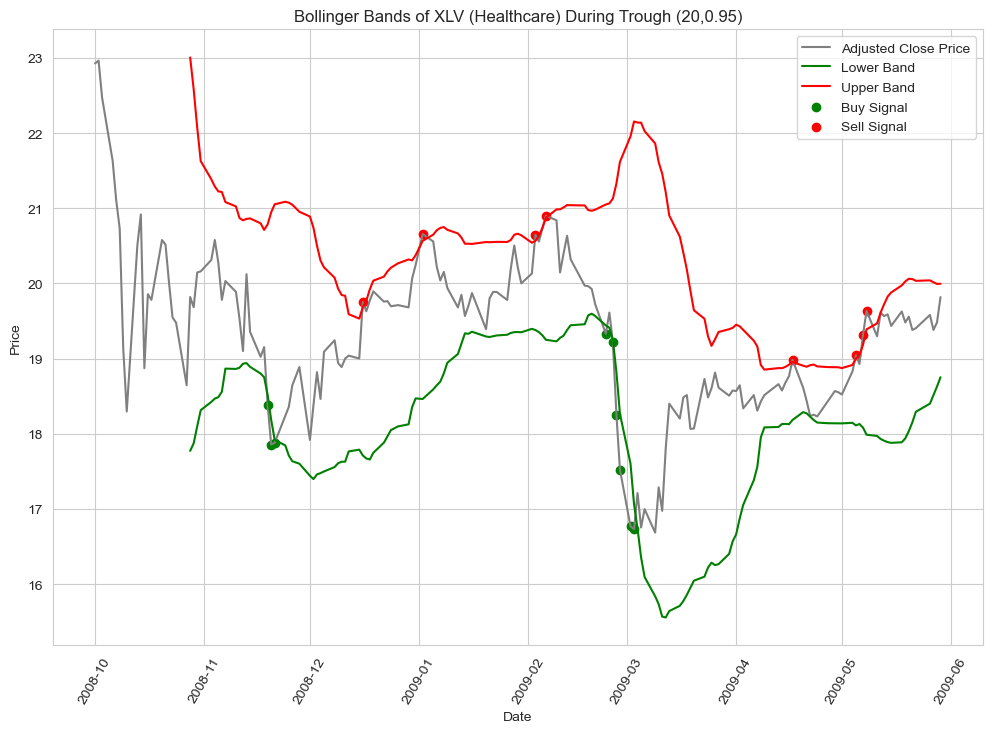

In [ ]:
# show the same example but with bollinger bands plotted for XLV during trough
plot_with_boll_bands(sector_etf_data['trough']['XLV'],'Bollinger Bands of XLV (Healthcare) During Trough (20,0.95)')

The visualization shows where the buy and sell signals are suggested for the XLV healthcare sector ETF during a trough. Observe that the signals take place when the rolling average falls or rises above the channel.

In [ ]:
# observe the dates for the buy and sell signals as seen in the graph
signals_list = list_signals(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)
signals_list['trough']['XLV']

{'Buy': [Timestamp('2008-11-19 00:00:00'),
  Timestamp('2008-11-20 00:00:00'),
  Timestamp('2008-11-21 00:00:00'),
  Timestamp('2009-02-23 00:00:00'),
  Timestamp('2009-02-25 00:00:00'),
  Timestamp('2009-02-26 00:00:00'),
  Timestamp('2009-02-27 00:00:00'),
  Timestamp('2009-03-02 00:00:00'),
  Timestamp('2009-03-03 00:00:00')],
 'Sell': [Timestamp('2008-12-16 00:00:00'),
  Timestamp('2009-01-02 00:00:00'),
  Timestamp('2009-02-03 00:00:00'),
  Timestamp('2009-02-06 00:00:00'),
  Timestamp('2009-04-17 00:00:00'),
  Timestamp('2009-05-05 00:00:00'),
  Timestamp('2009-05-07 00:00:00'),
  Timestamp('2009-05-08 00:00:00')]}

This graph shows the movement of the healthcare sector ETF (XLV) during a trough. The buy signals are bought when the stock is locally moving down where as the stock is sold when the stock is moving up locally. There are 9 buy signals and 8 sell signals.

## Stochastic Modeling for Bollinger Bands
To understand Bollinger Bands it is important to test how they perform on return on investments during different periods. Not just once as there is lot of deviation for expected return, it is best to repeat the investment a number of times during the same periods using the same sector ETFs this is so you can get a broader understanding of the probability of a specific return on investment occurring.

Parameters
Investment period: 90 days
Collect sector ETF closing price
Collect signals for sector ETF

There will be n random samples of start dates from the macroeconomic cycle which will then perform the Bollinger Band investment strategy for 90 days and return the investment n times to understand the distribution function of returns.

In [ ]:
# get the adjusted close price dataframe
sector_etf_closed_price = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [ ]:
# load in the dataframe for the trough time period
sector_etf_closed_price['trough']

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,23.119268,21.858332,12.413447,15.649688,22.589600,18.009502,37.393250,22.927486,36.648029,18.666510,34.011745
2008-10-02,21.458338,20.549885,11.794874,15.037064,21.771833,17.782761,35.261120,22.965382,35.561871,18.395729,31.759169
2008-10-03,21.247198,20.222767,11.278400,14.822247,21.010752,17.640244,34.840702,22.472731,35.039406,18.119320,30.064144
2008-10-06,20.198563,19.692127,10.689857,14.002765,20.419701,17.128460,32.966839,21.631422,33.396389,17.233648,29.512161
2008-10-07,19.156969,19.037905,9.560815,13.286714,19.108040,16.584286,31.159039,21.108444,31.966490,16.528509,27.019827
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,18.848711,16.073530,7.178291,13.618087,18.520384,15.070184,29.497374,19.404520,33.037407,14.918153,18.541616
2009-05-26,19.300228,16.658960,7.412229,13.971799,19.143749,15.260781,30.122383,19.580992,34.221874,15.351324,19.500553
2009-05-27,18.576378,16.117998,7.190606,13.835135,18.725445,14.873022,29.794708,19.381498,33.881420,15.039447,18.851517


In [ ]:
# get the signals for tickers
bb_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)
bb_signals['trough'].iloc[20:40]

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-29,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-30,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-31,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-03,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-04,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-05,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-06,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-07,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-11-10,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold


The signals and adjusted close price will be used as data with the same rows/columns in a way similar to a 3D table. Where the rows are the days, columns are the tickers and the width is the two sheets of adjusted close and bollinger band action page. This is going to be a useful structure when incorporating multiple signals on a given day.

### Base Model
- 20 day period 
- 2 standard deviations
- 20% of balance buy amount
- 20% of shares number sell amount

In [ ]:
# simulate stock investment 1000 times to get a distribution of returns
base_model_returns = zip_calculate_stock_roi(bb_signals,adj_close_sector_etf,economic_cycle_periods,sector_etf_tickers,1000,0,100,0.2,0.2)

In [ ]:
# get the average returns for sector ETF's
base_model_returns_mean = stochastic_roi(sector_etf_tickers,economic_cycle_periods,base_model_returns,'Mean')
base_model_returns_mean

,trough,expansion,peak,contraction,all_data
XLB,6.702497,1.913016,3.66521,1.15087,1.03517
XLI,5.326447,2.496345,3.453578,-0.340563,1.226377
XLF,2.364501,2.400956,5.515442,-0.863614,1.221295
XLK,3.486855,2.075044,2.750496,-0.931076,1.597405
XLY,7.656999,2.227845,2.329082,1.666878,1.319513
XLP,1.926529,2.110135,1.023853,1.10171,1.345057
XLE,4.90929,1.261691,1.999342,1.709203,1.141006
XLV,2.68524,2.508508,2.152082,-0.211898,1.431795
VOX,8.366082,1.377198,2.644925,-1.328792,1.060211
XLU,-0.720127,1.047786,1.161607,-1.357906,1.092414


In [ ]:
base_model_returns_mean.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/base_model_bollinger_bands.csv')

The distribution of XLV during a trough does not have any clear pattern. Unlike the buy and hold strategy which showed a relatively normally distributed graoh for each sector etf, it does not seem to be the case for bollinger bands. As there are only a certain number of buy and sell signals within the short time span of trough even though there are 1000 iterations of the process, it is not being tested on a large variety of buy and sell signals.

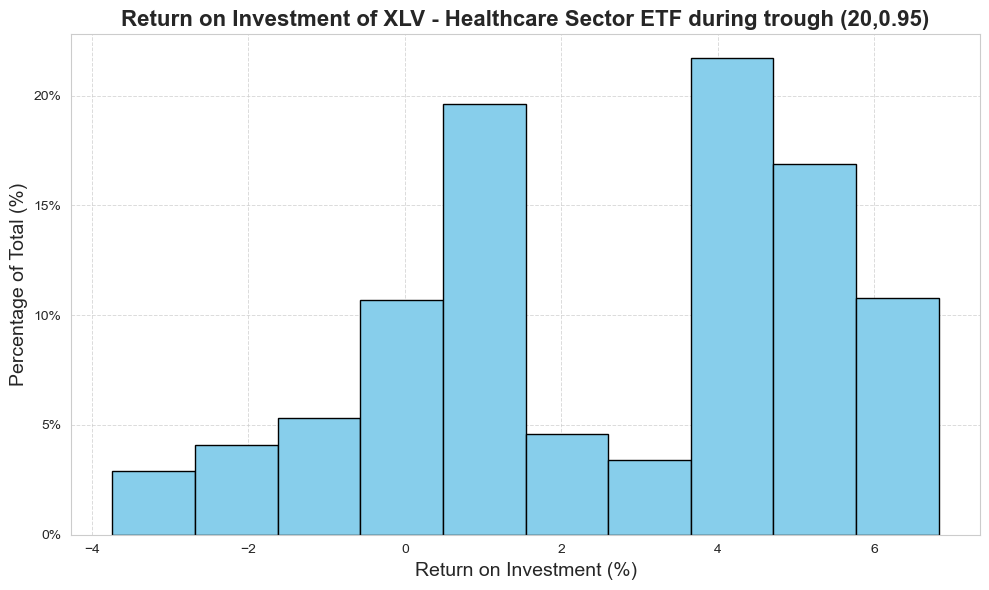

In [ ]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=base_model_returns['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough (20,0.95)',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

There is both a large difference in stocks during different time periods and sectors within the same time period. For example if you look at a contraction while there is a 2.5% increase in 90 days for real estate, there is a 1.5% decrease in communication services and utilities.

In [ ]:
base_model_returns_mean.mean()

trough         4.019847
expansion      1.850778
peak           2.511158
contraction    0.315176
all_data       1.245245
dtype: float64

By averaging returns you get a good understanding of which time period the investment period works best. Even though a peak or an expansion you would expect to be the highest return such as when using a buy and hold strategy, the trough period actually showed the highest return. This is likely due to the higher volatility which allows for bollinger bands to find more time short time highs and lows, where as long term expansions do not create as many buy signals to keep up with the upward pressure on the sell signals.

#### Machine Learning Optimization Model
Bollinger bands are made up of two parameters. The rolling average and confidence interval (stadard deviation). These two have a dynamic relationship with one another with their overall impact on the return on investment changing drastically depending on these values. The base model was one where John Bollinger encouraged a 20 day investment period with a 2 standard deviaiton which equates to about 95% confidence interval. This is going to be further investigated using hyperparameter tuning which will test the combination of different discrete sets of values to maximize returns. 

#### Hyperparameter Tuning
Using a list of discrete values for the rolling windows and confidence interval, a grid search can be done to find the optimal values for the maximum return on investment.

In [ ]:

# create the dictionary for rolling windows and confidence intervals
bb_parameters = {
    'rolling_windows':[10,15,20,25,30],# this is the rolling average it requires n days before an investment can be made
    'confidence_intervals':[0.85,0.90,0.95]
}

# perform the grid search funciton which is going to brute force test each combination of rolling windows and confidence intervals
grid_search_bollinger_bands = grid_search_bollinger_bands(sector_etf_data,sector_etf_closed_price,bb_parameters,economic_cycle_periods_list,economic_cycle_periods,sector_etf_tickers,1000,0,100,0.20,0.2)

In [ ]:
# list the results of the hyperparameter tuning based on the average ROI across the sector etfs across each period
grid_search_bollinger_bands.sort_values(by='all_data',ascending=False)

,rolling_window,confidence_interval,trough,expansion,peak,contraction,all_data
3,15,0.85,3.091166,2.314633,3.126965,-0.009156,1.664853
0,10,0.85,2.535766,2.111481,2.681779,0.321985,1.615614
6,20,0.85,3.075715,2.286905,3.344780,-0.214716,1.594008
4,15,0.90,3.854018,2.167686,2.873601,0.459654,1.582817
7,20,0.90,3.755462,2.295771,3.260394,0.067864,1.580966
12,30,0.85,3.941782,2.170782,2.729484,-0.279226,1.537304
9,25,0.85,4.017385,2.185585,3.311261,-0.143344,1.524352
10,25,0.90,4.994899,2.128057,2.850656,-0.041803,1.503643
13,30,0.90,6.117529,2.109313,2.239148,0.066997,1.482896
1,10,0.90,3.855220,1.961168,2.575657,0.091974,1.423113


In [ ]:
grid_search_bollinger_bands.sort_values(by='trough',ascending=False)


,rolling_window,confidence_interval,trough,expansion,peak,contraction,all_data
14,30,0.95,6.434381,1.903206,1.686609,0.286005,1.235370
13,30,0.90,6.117529,2.109313,2.239148,0.066997,1.482896
11,25,0.95,5.240305,1.856247,2.152549,0.005360,1.267641
10,25,0.90,4.994899,2.128057,2.850656,-0.041803,1.503643
8,20,0.95,4.019847,1.850778,2.511158,0.315176,1.245245
9,25,0.85,4.017385,2.185585,3.311261,-0.143344,1.524352
12,30,0.85,3.941782,2.170782,2.729484,-0.279226,1.537304
1,10,0.90,3.855220,1.961168,2.575657,0.091974,1.423113
4,15,0.90,3.854018,2.167686,2.873601,0.459654,1.582817
7,20,0.90,3.755462,2.295771,3.260394,0.067864,1.580966


There is a clear indication that using a lower confidence interval will lead to a more successful model across all data but a more strict confidence interval with higher rolling averages will perform best during a trough. Will use the model that is best for all_data but keeping in mind that trough does very well with more strict rules.

#### Optimized Bollinger Bands Model
By using grid search using the parameters, there has different combinations trialed 1000 times for each period and each ticker this is quite a lot of processing. The most optimal Bollinger Band during these time periods would be the following:
- rolling_window = 30
- confidence_interval = 0.95

Bollinger Bands are going to be used for their ability to perform 

In [ ]:
# create relevant bollinger band signals
optimized_sector_etf_data = bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,15,0.85)

# obtain the signals for tickers in periods
optimized_signals = collect_signals(optimized_sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

# get the average return across different stochastic modeling
optimizied_return = zip_calculate_stock_roi(optimized_signals,adj_close_sector_etf,economic_cycle_periods,sector_etf_tickers,1000,0,100,0.20,0.20)

# return the average return
optimized_average_returns = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,optimizied_return,'Mean')

# display the dataframe
optimized_average_returns

,trough,expansion,peak,contraction,all_data
XLB,4.88369,2.649782,3.941462,1.943751,1.735428
XLI,-1.047922,3.041184,5.642046,0.249905,1.825884
XLF,-0.485437,2.970656,5.279644,-1.94526,1.797621
XLK,6.767633,2.111932,3.830599,-0.946361,2.070183
XLY,7.909343,2.888559,2.972646,-0.958332,1.667761
XLP,-0.314015,2.321041,1.757164,1.49481,1.445792
XLE,5.744832,1.69799,2.165222,1.173078,1.212687
XLV,1.142661,3.417405,2.714992,-0.52265,1.908977
VOX,10.917948,2.083097,2.838,-2.165358,1.410906
XLU,-1.981577,1.191439,1.685121,-1.280664,1.579477


In [ ]:
# save the data as a csv
optimized_average_returns.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/optimized_bollinger_bands.csv')

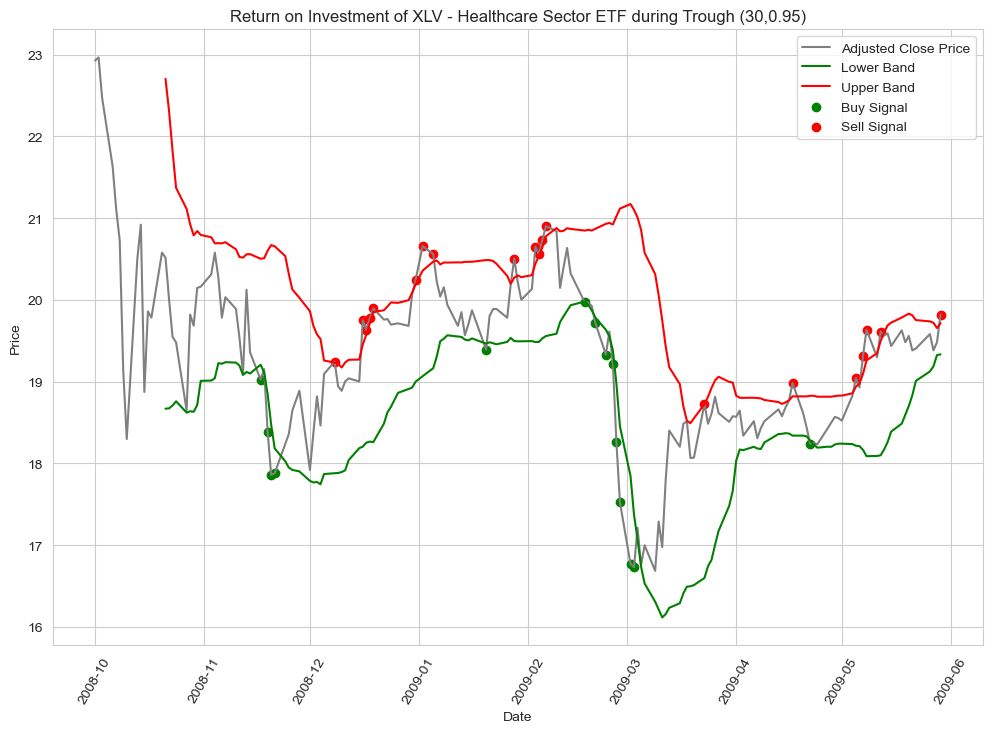

In [ ]:
plot_with_boll_bands(optimized_sector_etf_data['trough']['XLV'],'Return on Investment of XLV - Healthcare Sector ETF during Trough (30,0.95)')

In [ ]:
# average the return for the different sector etfs during the different periods
optimized_average_returns.mean()

trough         3.091166
expansion      2.314633
peak           3.126965
contraction   -0.009156
all_data       1.664853
dtype: float64

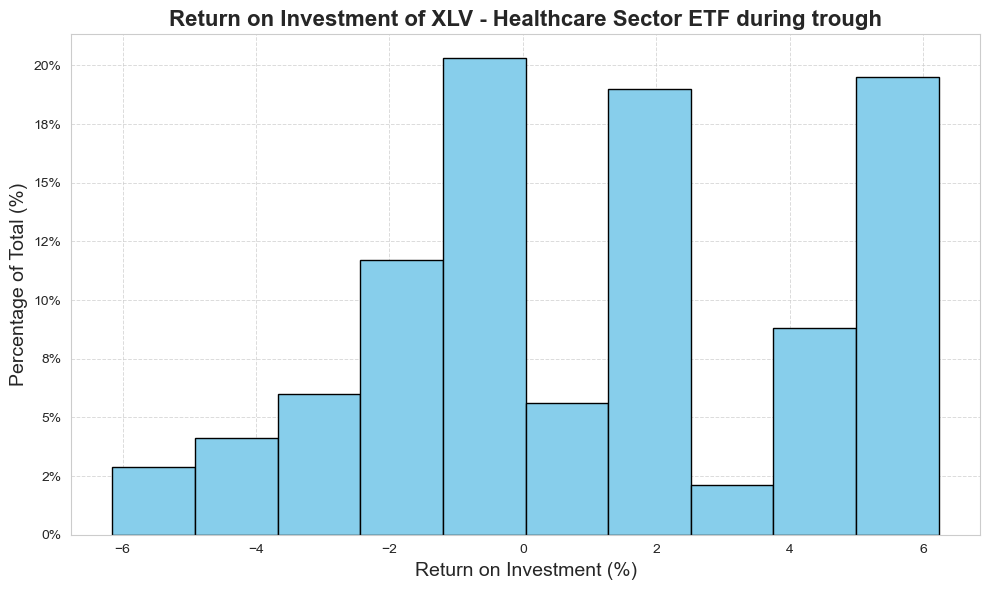

In [ ]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=optimizied_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

Observe that with this parameter set for bollinger bands there are more signals of buying and selling but it takes longer for the investments to start to create the rolling average period. 

### Price Investment Optimized Model
As seen above it is clear that during different time periods there are far more sell signals such as expansion and trough compared to buy signals. It is possible that by testing different combinations of parameter optimization you might be able to find a better investment rate such as a higher buy percentage amount and a lower sell percentage amount.

In [ ]:
# get the parameter options as a dictionary with lists for percentage amount to buy and percentage amount to sell
param_grid_price = {
    'amount_to_buy': [0.10, 0.20, 0.25, 0.30],
    'amount_to_sell': [0.10, 0.20, 0.25, 0.30]
}

# Call the function
invest_buy_sell_returns = investment_amount_grid_search_bollinger_bands(
    sector_etf_data, 
    sector_etf_closed_price, 
    param_grid_price, 
    economic_cycle_periods_list, 
    economic_cycle_periods, 
    sector_etf_tickers, 
    1000,
    0,
    100
)

In [ ]:
invest_buy_sell_returns.sort_values(by='all_data',ascending=False)

,amount_to_buy,amount_to_sell,trough,expansion,peak,contraction,all_data
12,0.30,0.10,6.059411,2.592209,2.778084,-0.173577,1.824650
8,0.25,0.10,6.325680,2.444960,2.559132,-0.110672,1.721006
13,0.30,0.20,5.693052,2.439730,2.716719,-0.080371,1.702401
14,0.30,0.25,5.561693,2.388809,2.704982,-0.053190,1.660694
15,0.30,0.30,5.460896,2.347862,2.697786,-0.032379,1.627758
9,0.25,0.20,5.939440,2.302512,2.506130,-0.016294,1.607476
4,0.20,0.10,6.516960,2.238750,2.282692,-0.028153,1.585347
10,0.25,0.25,5.799085,2.254967,2.495748,0.011513,1.568736
11,0.25,0.30,5.689739,2.216756,2.489098,0.032788,1.538130
5,0.20,0.20,6.117529,2.109313,2.239148,0.066997,1.482896


In [ ]:
invest_optimizied_bb_average_return = zip_calculate_stock_roi(bb_signals,adj_close_sector_etf,economic_cycle_periods,sector_etf_tickers,1000,0,100,0.30,0.10)
invest_optimized_average_returns = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,invest_optimizied_bb_average_return,'Mean')
invest_optimized_average_returns

,trough,expansion,peak,contraction,all_data
XLB,9.895802,2.298507,4.643599,1.279952,1.380139
XLI,5.452938,3.173856,4.77578,-0.692013,1.66189
XLF,2.030728,3.095306,7.200204,-2.476035,1.473299
XLK,5.20481,2.583017,4.281166,-1.319664,2.114858
XLY,10.369021,2.919329,2.825838,1.80476,1.679305
XLP,1.79554,2.767889,1.458045,1.318136,1.752089
XLE,6.063827,1.513193,2.159568,2.590282,1.601214
XLV,2.664937,3.511774,3.327352,-0.21901,1.860957
VOX,10.444121,1.762672,3.680276,-1.906668,1.304246
XLU,-1.031868,1.33374,1.637882,-1.703906,1.338292


In [ ]:
invest_optimized_average_returns.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/invest_optimized_average_returns.csv')

In [ ]:
invest_optimized_average_returns.mean()

trough         5.039370
expansion      2.400861
peak           3.374184
contraction    0.215462
all_data       1.610462
dtype: float64

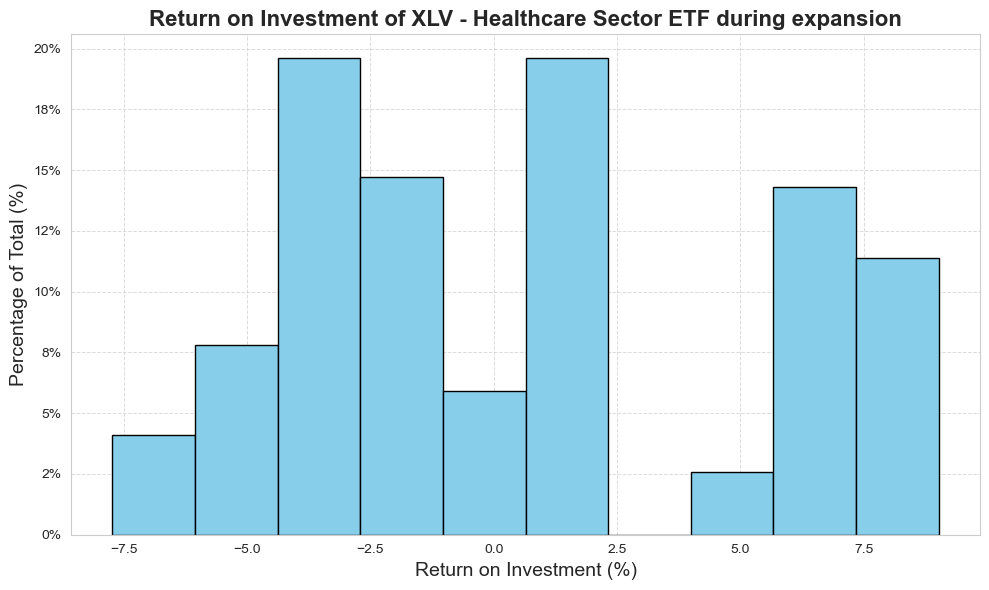

In [ ]:
# plot the histogram of the XLV healthcare during an expansion
plot_percentage_histogram(
    data=invest_optimizied_bb_average_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during expansion',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

In [ ]:
# Call the function
invest_buy_sell_returns_optimal = investment_amount_grid_search_bollinger_bands(
    optimized_sector_etf_data, 
    sector_etf_closed_price, 
    param_grid_price, 
    economic_cycle_periods_list, 
    economic_cycle_periods, 
    sector_etf_tickers, 
    1000,
    0,
    100
)

In [ ]:
invest_buy_sell_returns_optimal.sort_values(by='all_data',ascending=False)

,amount_to_buy,amount_to_sell,trough,expansion,peak,contraction,all_data
12,0.35,0.10,5.781729,2.698437,2.955771,-0.221965,1.906438
8,0.30,0.10,6.059411,2.592209,2.778084,-0.173577,1.824650
13,0.35,0.20,5.436822,2.537947,2.887118,-0.129639,1.777163
14,0.35,0.25,5.314979,2.484361,2.874318,-0.102884,1.733081
4,0.25,0.10,6.325680,2.444960,2.559132,-0.110672,1.721006
9,0.30,0.20,5.693052,2.439730,2.716719,-0.080371,1.702401
15,0.35,0.30,5.223043,2.441271,2.866799,-0.082352,1.698287
10,0.30,0.25,5.561693,2.388809,2.704982,-0.053190,1.660694
11,0.30,0.30,5.460896,2.347862,2.697786,-0.032379,1.627758
5,0.25,0.20,5.939440,2.302512,2.506130,-0.016294,1.607476


In [ ]:
price_parameters_optimal_returns = zip_calculate_stock_roi(bb_signals,sector_etf_closed_price,economic_cycle_periods,sector_etf_tickers,1000,0,100,0.35,0.10)
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,price_parameters_optimal_returns,'Mean')

In [ ]:
optimal_parameters_invest_average_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,price_parameters_optimal_returns,'Mean')
optimal_parameters_invest_average_return

,trough,expansion,peak,contraction,all_data
XLB,11.174143,2.448378,5.049948,1.47234,1.505474
XLI,5.515256,3.411723,5.340035,-0.869483,1.811709
XLF,1.267034,3.337193,7.777872,-3.145847,1.562483
XLK,6.071917,2.73236,4.881072,-1.431122,2.272307
XLY,11.241555,3.169107,3.005518,1.907679,1.790862
XLP,1.719281,2.966823,1.656164,1.387999,1.887602
XLE,6.397671,1.615091,2.331141,2.954761,1.731746
XLV,2.573296,3.851332,3.779361,-0.268487,2.004733
VOX,11.041421,1.889704,4.093589,-2.151721,1.374642
XLU,-1.064681,1.412238,1.741253,-1.839586,1.41766


In [ ]:
optimal_parameters_invest_average_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/optimized_bb_invest_avg_return.csv')

In [ ]:
stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,price_parameters_optimal_returns,'Mean').mean()

trough         5.325221
expansion      2.587279
peak           3.712421
contraction    0.185063
all_data       1.730067
dtype: float64

### Buy and Hold with Bollinger Bands
As seen from exploring the Bollinger Band technique above, when the number of sell signals heavily outweights the number of buy signals, there are not enough opportunities for the stocks to continue to grow. Another approach that is going to be taken is by holding $50 of initial investment in the stock as well as $50 to be used to invest in the stocks.

In [ ]:
buy_hold_bb_list_returns = zip_calculate_stock_roi(bb_signals,sector_etf_closed_price,economic_cycle_periods,sector_etf_tickers,1000,50,50,0.20,0.20)

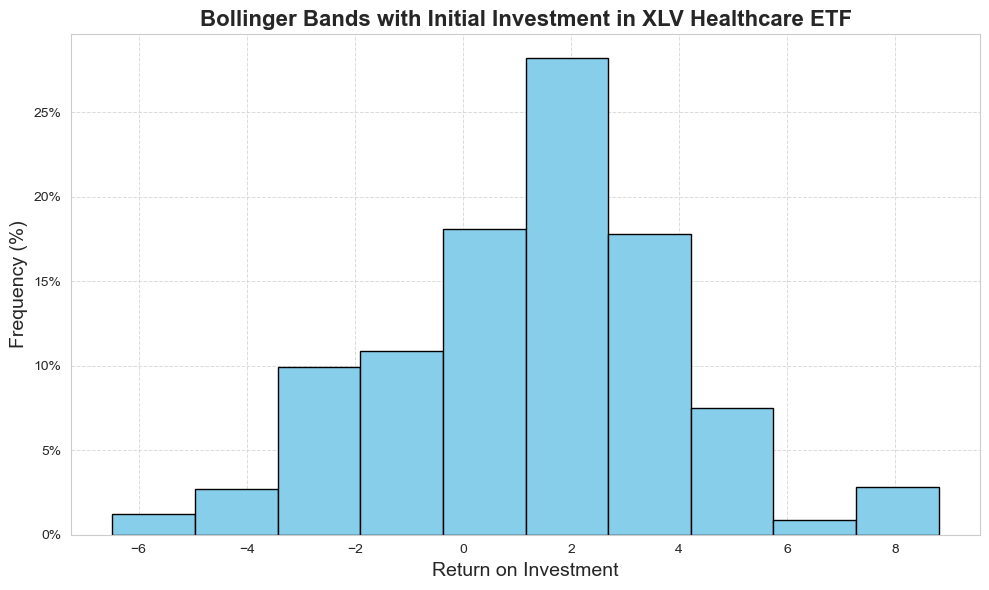

In [ ]:
plot_percentage_histogram(buy_hold_bb_list_returns['trough']['XLV'],'Bollinger Bands with Initial Investment in XLV Healthcare ETF','Return on Investment','Frequency (%)')

In [ ]:
initial_future_bb_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,buy_hold_bb_list_returns,'Mean')
initial_future_bb_return

,trough,expansion,peak,contraction,all_data
XLB,2.642008,2.628741,4.352659,0.965466,1.807454
XLI,1.364513,3.653108,4.775099,-2.270747,2.164055
XLF,-7.631828,3.862908,6.946091,-6.407878,1.998468
XLK,3.821126,3.082787,5.315928,-1.552045,2.790634
XLY,5.436647,3.72437,3.150253,-0.323284,2.225094
XLP,-0.51597,3.111223,2.625832,1.057921,2.068743
XLE,2.233581,1.6229,1.856971,2.408961,1.765249
XLV,1.273582,4.174149,3.830972,-1.981955,2.269273
VOX,6.409119,2.40123,4.040922,-2.512107,1.516678
XLU,-2.793816,2.103304,2.59315,-2.176317,1.996205


In [ ]:
initial_future_bb_return.mean()

trough         0.458102
expansion      2.933027
peak           3.821667
contraction   -1.022600
all_data       2.059155
dtype: float64

In [ ]:
initial_future_bb_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/bollinger_band/buy_hold_bollinger.csv')

In [ ]:
# test the different values to create relationship between return and impact of a bollinger band versus initial investment
initial_relatie_to_cash_param = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,200,250,300,400,500]

initial_relative_cash_returns = initial_future_grid_search_bb(sector_etf_data,adj_close_sector_etf,initial_relatie_to_cash_param,economic_cycle_periods_list,economic_cycle_periods,sector_etf_tickers,1000,0.2,0.2,20,0.95)

In [ ]:
grid_results.sort_values(by='all_data',ascending=False)

,Percentage of Cash Balance to Begin With,trough,expansion,peak,contraction,all_data
20,500,-1.916395,3.654527,4.695339,-1.914451,2.601762
19,400,-1.678945,3.582377,4.607972,-1.825266,2.547501
18,300,-1.322770,3.474152,4.476921,-1.691489,2.466110
17,250,-1.068360,3.396849,4.383313,-1.595933,2.407974
16,200,-0.729146,3.293777,4.258503,-1.468526,2.330459
15,150,-0.254247,3.149477,4.083768,-1.290156,2.221937
14,140,-0.135522,3.113402,4.040085,-1.245563,2.194807
13,130,-0.006473,3.074190,3.992603,-1.197093,2.165317
12,120,0.134307,3.031414,3.940804,-1.144216,2.133147
11,110,0.288495,2.984563,3.884072,-1.086304,2.097913


In [ ]:
grid_results.drop(columns='index',inplace=True)

In [ ]:
grid_results.set_index('Percentage of Cash Balance to Begin With',inplace=True)

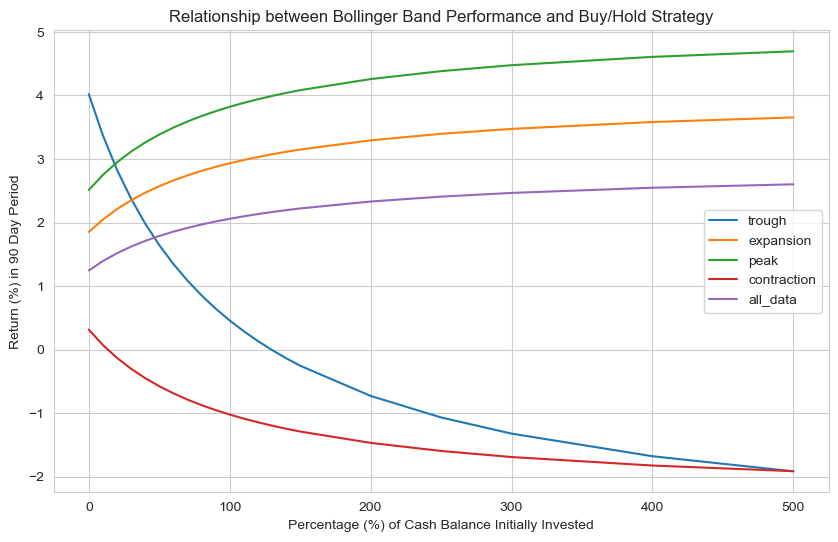

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(grid_results.index, grid_results,label=grid_results.columns)
plt.xlabel('Percentage (%) of Cash Balance Initially Invested')
plt.ylabel('Return (%) in 90 Day Period')
plt.title('Relationship between Bollinger Band Performance and Buy/Hold Strategy')
plt.legend()

The relationship for trough looks to be an inverse exponential curve. By taking the inverse exponential of the output observe how closely it resembles a linear model.

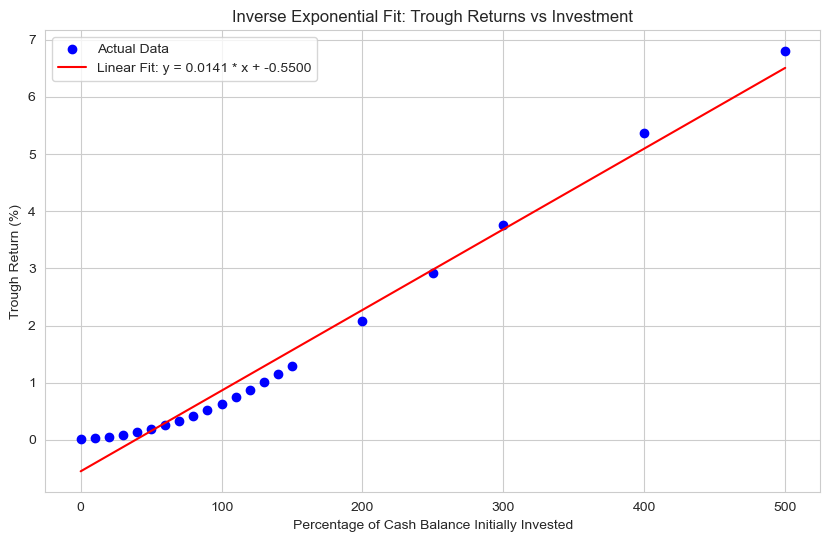

In [ ]:
from sklearn.linear_model import LinearRegression
import sympy as sp  # Import sympy for symbolic math

# Data Preparation
x_linear = pd.Series(grid_results.index).values.reshape(-1, 1)
y = grid_results['trough']
y_transformed = 1/np.exp(y) # Transformation

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_linear, y_transformed)
linear_y_pred = linear_model.predict(x_linear)
linear_b = linear_model.coef_[0]  # Slope
linear_intercept = linear_model.intercept_  # Intercept

# Plot the actual data vs. model prediction
plt.figure(figsize=(10, 6))
plt.scatter(x_linear, y_transformed, color='blue', label='Actual Data')
plt.plot(x_linear, linear_y_pred, color='red', label=f'Linear Fit: y = {linear_b:.4f} * x + {linear_intercept:.4f}')
plt.xlabel('Percentage of Cash Balance Initially Invested')
plt.ylabel('Trough Return (%)')
plt.title('Inverse Exponential Fit: Trough Returns vs Investment')
plt.legend()
plt.show()

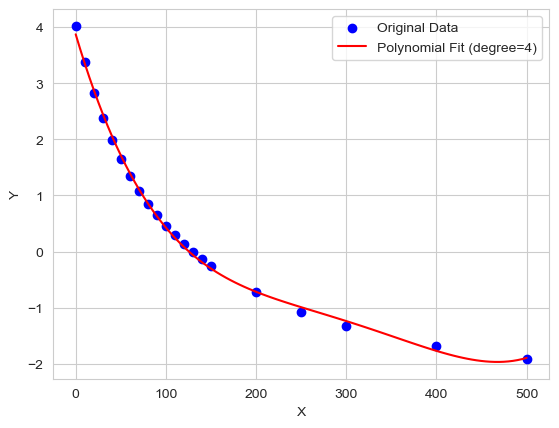

In [ ]:
# Choose the degree of the polynomial (e.g., 2 for quadratic)
degree = 4

# Fit the polynomial using np.polyfit
coefficients = np.polyfit(x, y, degree)

# Create a polynomial function using np.poly1d
polynomial = np.poly1d(coefficients)

# Generate values for the fitted curve
x_fit = np.linspace(min(x), max(x), 100)
y_fit = polynomial(x_fit)

# Plot the original data and the fitted polynomial
plt.scatter(x, y, color='blue', label='Original Data')
plt.plot(x_fit, y_fit, color='red', label=f'Polynomial Fit (degree={degree})')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [ ]:
x_symbolic = sp.symbols('x')
polynomial_expr = sum(coef * x_symbolic**(degree-i) for i, coef in enumerate(coefficients))
print("Polynomial Equation:")
sp.init_printing()  # Enables nicer printing of sympy objects
sp.pprint(polynomial_expr)

Polynomial Equation:
                      4                        3                         2    
4.36203734782062e-10⋅x  - 5.41439187483199e-7⋅x  + 0.000246905736764132⋅x  - 0

                                      
.0541474862099712⋅x + 3.87019938294448


/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_26410/3856916700.py:1: RuntimeWarning: invalid value encountered in log
  y_model = -np.log(linear_y_pred)


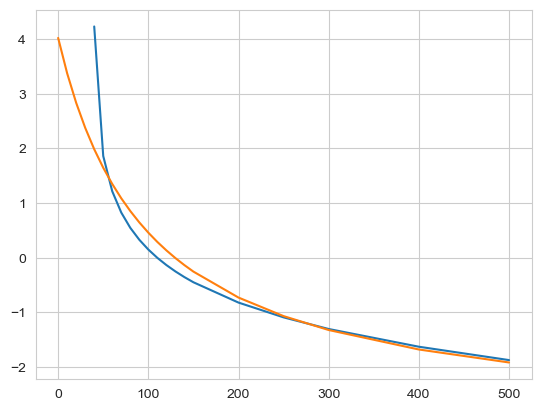

In [ ]:
y_model = -np.log(linear_y_pred)

plt.plot(x,y_model)
plt.plot(x,y)